In [52]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm 
import scipy.special as sp
import itertools
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import cross_val_score

In [4]:
data_plot=pd.read_csv('prostate.data', sep='\t')
data_plot.drop(columns=data_plot.columns[0], inplace=True)

train=pd.Series(data_plot.loc[:,'train'])
data_plot.drop(columns='train', inplace=True)

lpsa=pd.Series(data_plot.loc[:,'lpsa'])
predictors=pd.DataFrame(data_plot.drop(columns='lpsa'))

# Selezionare i dati di training e testing
dataTrain = data_plot.loc[train == 'T'].reset_index(drop=True) #necessario resettare indici
dataTest = data_plot.loc[train == 'F'].reset_index(drop=True)

# Selezionare la serie 'lpsa' dai dati di training e testing
lpsaTrain = pd.Series(dataTrain['lpsa'])
lpsaTest = pd.Series(dataTest['lpsa'])

predictorsTrain=pd.DataFrame(dataTrain.drop(columns='lpsa'))
predictorsTest=pd.DataFrame(dataTest.drop(columns='lpsa'))

scaler = StandardScaler()
predictorsTrain_std = pd.DataFrame(scaler.fit_transform(predictorsTrain), columns=predictorsTrain.columns)
predictorsTest_std = pd.DataFrame(scaler.transform(predictorsTest), columns=predictorsTrain.columns)

data_train=sm.add_constant(predictorsTrain_std)
data_test=sm.add_constant(predictorsTest_std)

In [17]:
# Inizializzare il modello di regressione Ridge con alpha=1.0
ridge_model = Ridge(alpha=1.0)

# Addestrare il modello sui dati di training standardizzati
ridge_model.fit(predictorsTrain_std, lpsaTrain)

# Effettuare le predizioni sui dati di test standardizzati
lpsa_pred_train = ridge_model.predict(predictorsTrain_std)
lpsa_pred_test = ridge_model.predict(predictorsTest_std)

# Valutare le prestazioni del modello
mse_train = mean_squared_error(lpsaTrain, lpsa_pred_train)
r2_train = r2_score(lpsaTrain, lpsa_pred_train)

mse_test = mean_squared_error(lpsaTest, lpsa_pred_test)
r2_test = r2_score(lpsaTest, lpsa_pred_test)

print(f"Mean Squared Error (Train): {mse_train}")
print(f"R^2 Score (Train): {r2_train}")
print(f"Mean Squared Error (Test): {mse_test}")
print(f"R^2 Score (Test): {r2_test}")

# Mostrare i coefficienti del modello e l'intercetta
coefficients = pd.Series(ridge_model.coef_, index=predictorsTrain.columns)
print("Coefficients:\n", coefficients)
print("Intercept:", ridge_model.intercept_)
print(predictorsTrain.columns)

Mean Squared Error (Train): 0.4397098588157029
R^2 Score (Train): 0.6940162194792774
Mean Squared Error (Test): 0.5125174233583769
R^2 Score (Test): 0.5117222864471653
Coefficients:
 lcavol     0.685410
lweight    0.289595
age       -0.134306
lbph       0.208411
svi        0.301625
lcp       -0.254532
gleason   -0.011252
pgg45      0.255985
dtype: float64
Intercept: 2.4523450850746262
Index(['lcavol', 'lweight', 'age', 'lbph', 'svi', 'lcp', 'gleason', 'pgg45'], dtype='object')


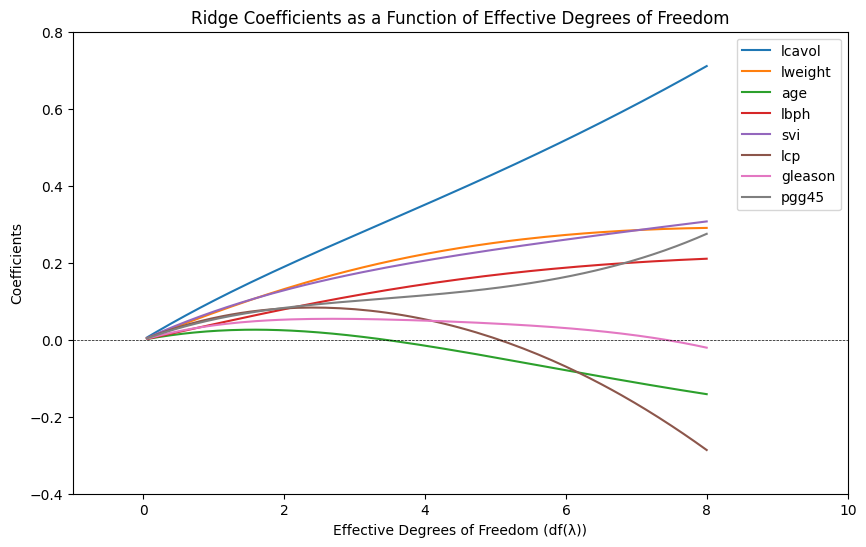

In [24]:
# Generare un vettore di parametri di regolarizzazione da 10^(-2) a 10^4 con 200 passi
alphas = np.logspace(-2, 4, 200)

# Preparare una lista vuota per i coefficienti e i gradi di libertà effettivi
coefficients_list = []
df_lambda = []

# Calcolare il modello di Ridge per ciascun valore di alpha e memorizzare i coefficienti e df(lambda)
for alpha in alphas:
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(predictorsTrain_std, lpsaTrain)
    coefficients_list.append(ridge_model.coef_)
    
    # Calcolare i gradi di libertà effettivi
    X = predictorsTrain_std.values
    I = np.identity(X.shape[1])
    H = X @ np.linalg.inv(X.T @ X + alpha * I) @ X.T
    df_lambda.append(np.trace(H))

# Convertire la lista di coefficienti in un array numpy
coefficients_array = np.array(coefficients_list)

# Tracciare i gradi di libertà effettivi contro i relativi coefficienti
plt.figure(figsize=(10, 6))
for i, column in enumerate(predictorsTrain.columns):
    plt.plot(df_lambda, coefficients_array[:, i], label=column)

plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)  # Traccia una linea y=0
plt.xlim(-1, 10)  
plt.ylim(-0.4, 0.8)  #
plt.xlabel('Effective Degrees of Freedom (df(λ))')
plt.ylabel('Coefficients')
plt.title('Ridge Coefficients as a Function of Effective Degrees of Freedom')
plt.legend(loc='best')
plt.show()
